## **ParamsOptimiser**: Optimise your model parameters with MEDfl

In the field of machine learning, scientists frequently engage in a process of experimenting with diverse model configurations, adjusting parameters from one experiment to another. This iterative approach is aimed at uncovering the optimal combination of parameters that can enhance a model's performance. Particularly in the medical domain, datasets often exhibit a significant class imbalance, posing challenges in constructing models with robust performance. The quest for identifying the most suitable parameters becomes crucial in achieving optimal results for such imbalanced datasets.

With `MEDfl`, users are empowered to efficiently explore and discover the best parameter combinations that yield optimal model performance. The platform facilitates the intricate task of parameter tuning, enabling practitioners to navigate the complexities associated with imbalanced medical datasets. Through systematic experimentation and automated parameter optimization, `MEDfl` streamlines the process of finding configurations that enhance model efficacy, ultimately contributing to more effective and reliable machine learning models in the medical field. 

to optimise your model parameters usingn MEDfl follow these steps:
1. **Define Parameter Configurations:**  a dictionary encapsulating diverse configurations of the selected parameters targeted for optimization. 

Parameter | Description             | ex.
----------| -----------------------|-------
hidden_dim|model hidden dimention | 'hidden_dim': [70 , 30]
lr        |Learning rate          |'lr': [0.001 , 0.001]
pos_weight|loss function weight    |  'pos_weight': [ 6 ,5]
th        |Threshhold               |'th': [0.3,0.4, 0.5]
max_epochs|max training iterations |    'max_epochs': [10, 20, 30] 
batch_size|The number of training examples utilized in one iteration |    'batch_size': [32, 40] 


```python
param_grid = {
    'hidden_dim': [70 , 30], 
    'lr': [0.001 , 0.001], 
    'pos_weight': [ 6 ,5], 
    'th': [0.3,0.4, 0.5], 
    'max_epochs': [10, 20, 30] 
}
```

2. **Select a Scoring Metric:** Identify a scoring metric, crucial for ranking configurations according to their performance scores in relation to the chosen metric.

In [1]:
from Medfl.LearningManager.utils import global_params

import sys
sys.path.append(global_params['base_url'])

import os
os.environ['PYTHONPATH'] = global_params['base_url']


Imports

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

# MEDfl imports 
from Medfl.LearningManager.params_optimiser import ParamsOptimiser

### Dataset
for this tutorial we will use the Mimic_train dataset

In [3]:
data = pd.read_csv( '../data/masterDataSet/Mimic_train.csv')

data.head()

,age,pao2fio2,uo,aids,hem,mets,admissiontype,bicarbonate,bilirubin,bun,gcs,hr,potassium,sbp,sodium,tempc,wbc,deceased
0,44.319070,6,4375.0,0.0,0.0,1.0,6.0,18.0,0.70,12.0,15.0,69.0,4.2,71.0,138.0,39.11,7.9,1
1,56.275504,6,1150.0,0.0,0.0,0.0,6.0,13.0,6.40,70.0,15.0,83.0,4.0,75.0,128.0,36.72,13.0,0
2,64.171038,6,790.0,0.0,0.0,0.0,8.0,18.0,1.47,46.0,14.0,58.0,5.2,86.0,131.0,37.28,14.8,0
3,82.255538,6,1652.0,0.0,0.0,0.0,0.0,23.0,1.39,13.0,13.0,61.0,4.3,95.0,135.0,36.67,10.6,0
4,75.884471,6,2540.0,0.0,0.0,0.0,8.0,24.0,1.99,10.0,12.0,41.0,3.9,92.0,136.0,37.11,7.9,0


In [4]:
# Define features and target variable
features = [col for col in data.columns if col != 'deceased']
target = 'deceased'

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


### Test Parameters
we define the param_grid dictionary 

In [5]:
param_grid = {
    'hidden_dim': [70, 20],
    'lr': [0.001 , 0.01],
    'pos_weight': [5,1,6],
    'th': [0.3, 0.5],
    'max_epochs': [10, 30]
}

### ParamsOptimiser

In [6]:
# Initiate the ParamsOptimiser class 

trainer = ParamsOptimiser(X_train, y_train)

In [34]:
# Perform grid search for recall
recall_grid_search = trainer.perform_grid_search(param_grid, scoring_metric='recall')

# Get the best parameters and the best score
print("Best Parameters:", recall_grid_search.best_params_)
print("Best Score:", recall_grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'hidden_dim': 70, 'lr': 0.001, 'max_epochs': 10, 'pos_weight': 5, 'th': 0.3}
Best Score: 1.0


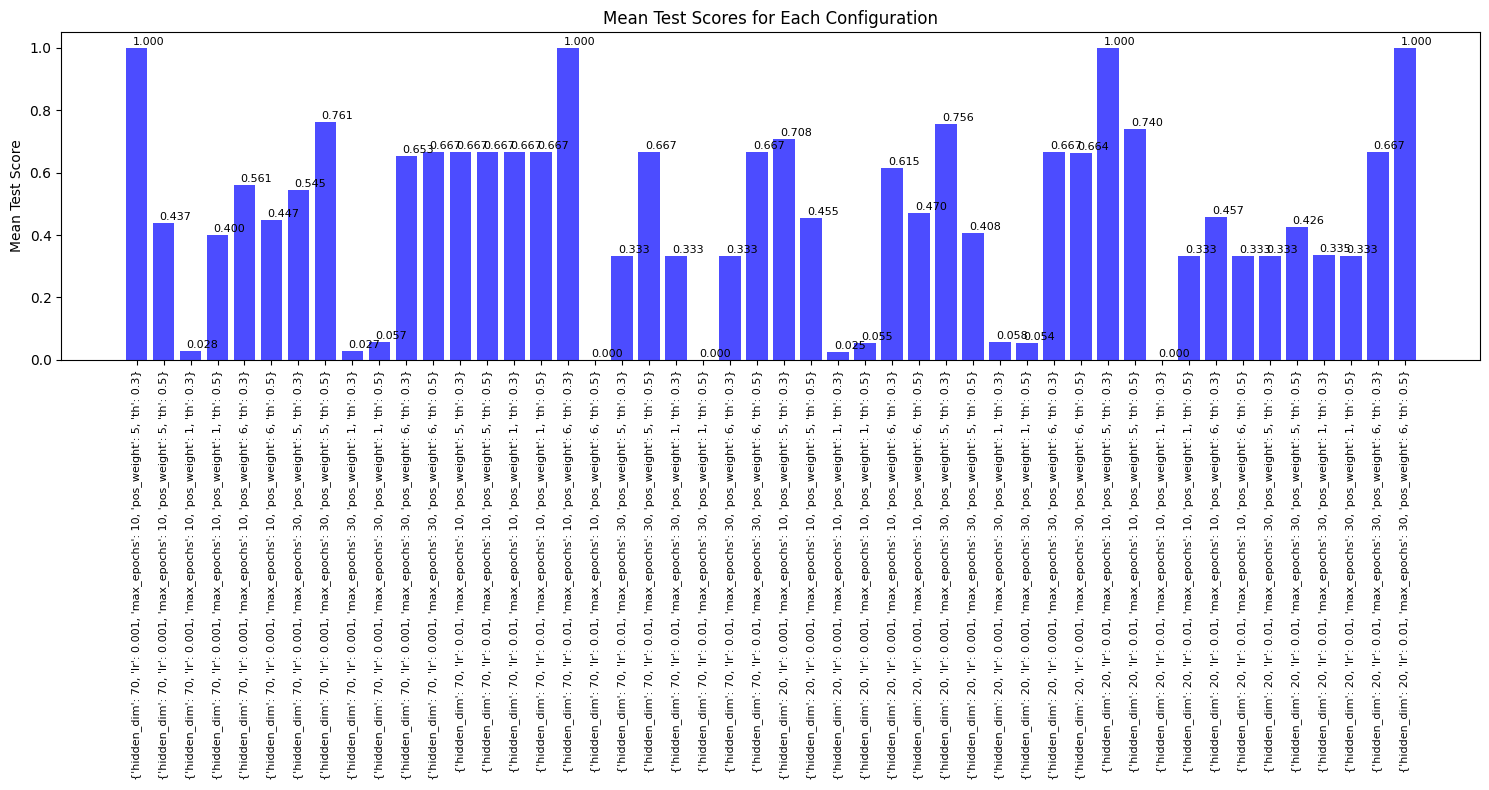

In [35]:
trainer.plot_results()

In [36]:
# Perform grid search for recall
precision_grid_search = trainer.perform_grid_search(param_grid, scoring_metric='precision')

# Get the best parameters and the best score
print("Best Parameters:", precision_grid_search.best_params_)
print("Best Score:", precision_grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/local/USHERBROOKE/saho6810/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/local/USHERBROOKE/saho6810/.local/lib

Best Parameters: {'hidden_dim': 70, 'lr': 0.001, 'max_epochs': 30, 'pos_weight': 1, 'th': 0.3}
Best Score: 0.5376344086021505


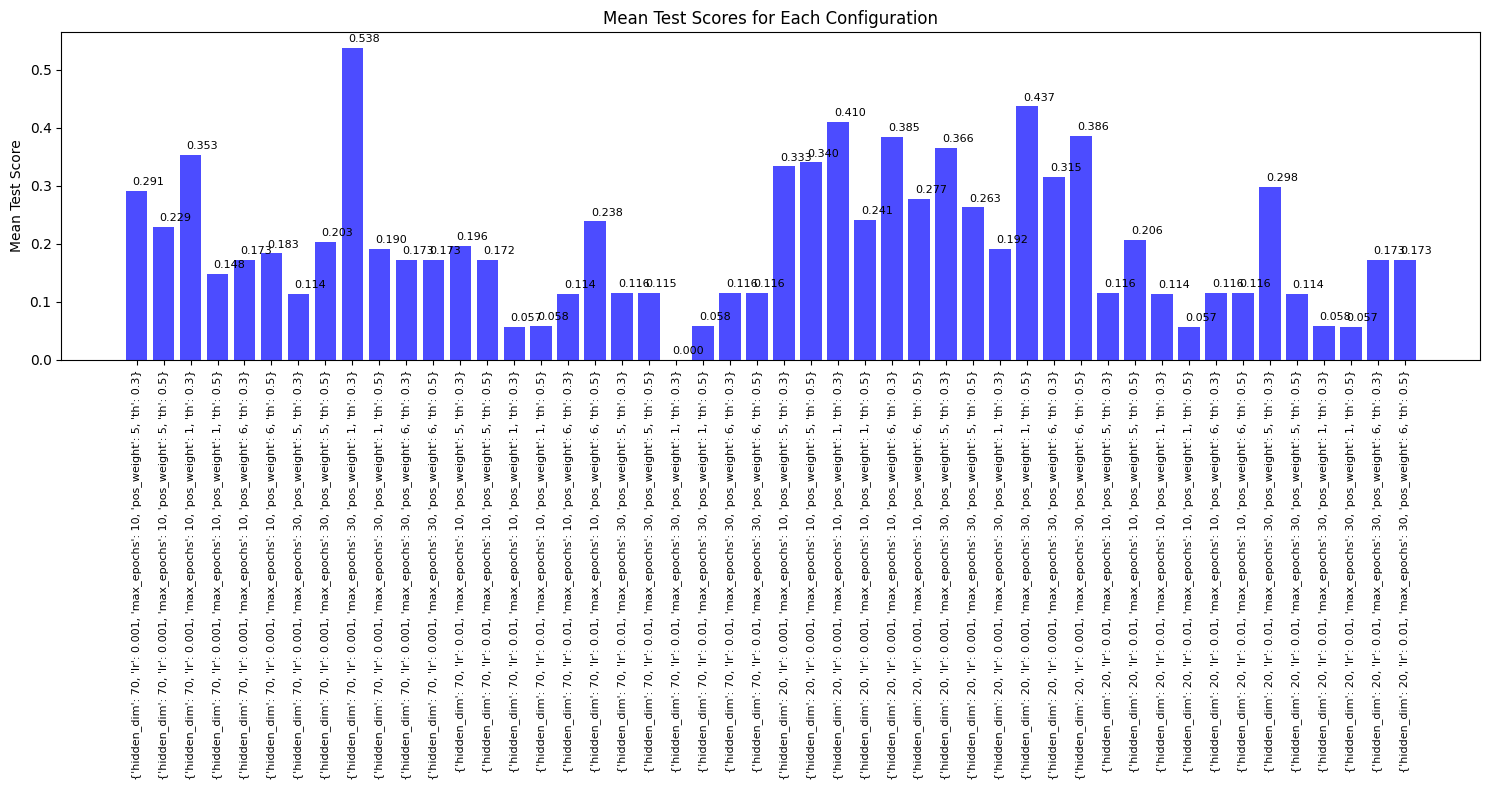

In [37]:
trainer.plot_results()

In [38]:
# Perform grid search for recall
precision_grid_search = trainer.perform_grid_search(param_grid, scoring_metric='accuracy')

# Get the best parameters and the best score
print("Best Parameters:", precision_grid_search.best_params_)
print("Best Score:", precision_grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'hidden_dim': 70, 'lr': 0.001, 'max_epochs': 30, 'pos_weight': 1, 'th': 0.5}
Best Score: 0.829608938547486


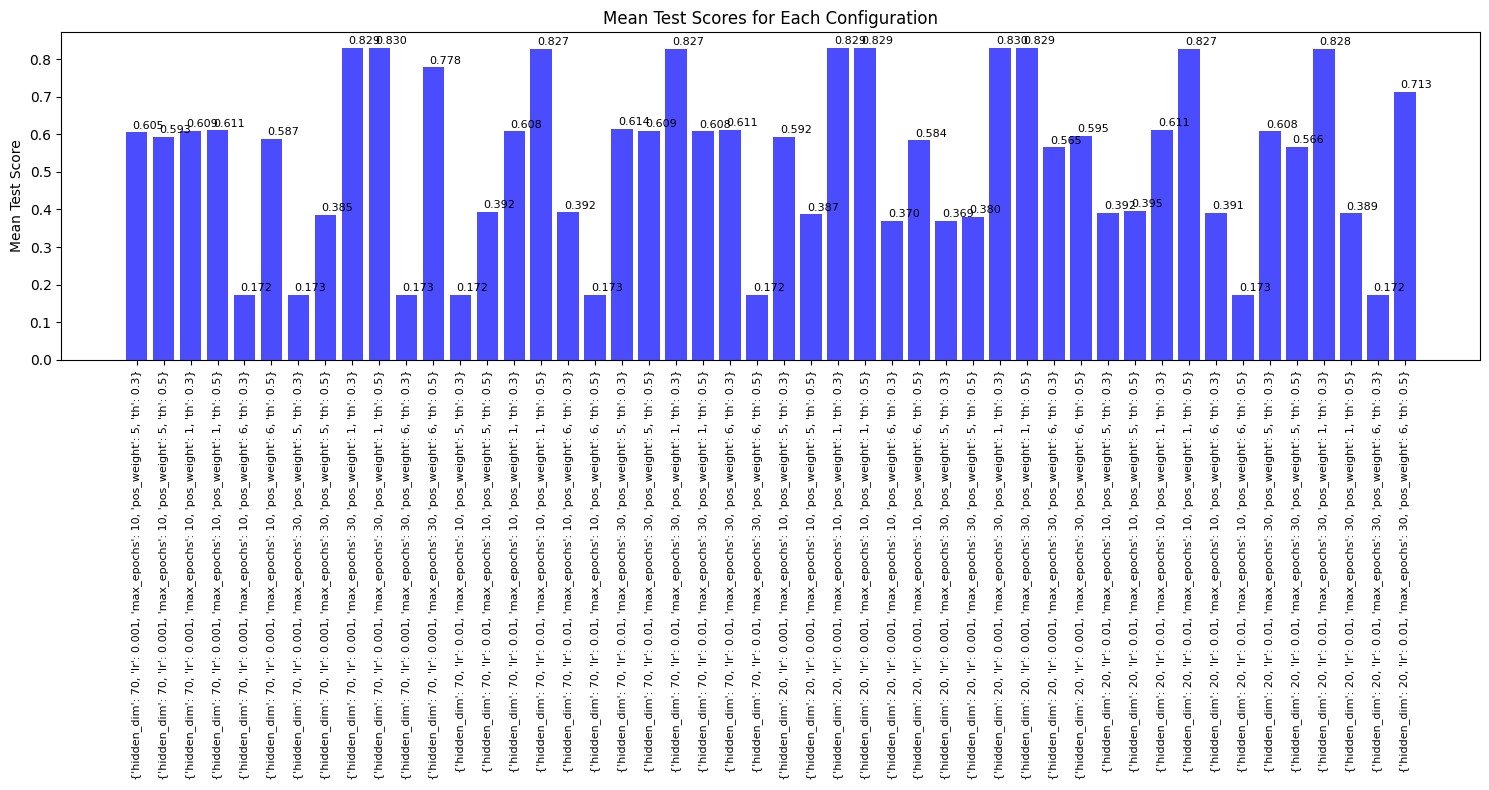

In [39]:
trainer.plot_results()

In [7]:
# Perform grid search for recall
recall_grid_search = trainer.perform_grid_search(param_grid, scoring_metric='f1')

# Get the best parameters and the best score
print("Best Parameters:", recall_grid_search.best_params_)
print("Best Score:", recall_grid_search.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'hidden_dim': 20, 'lr': 0.001, 'max_epochs': 30, 'pos_weight': 6, 'th': 0.5}
Best Score: 0.3829271472859456


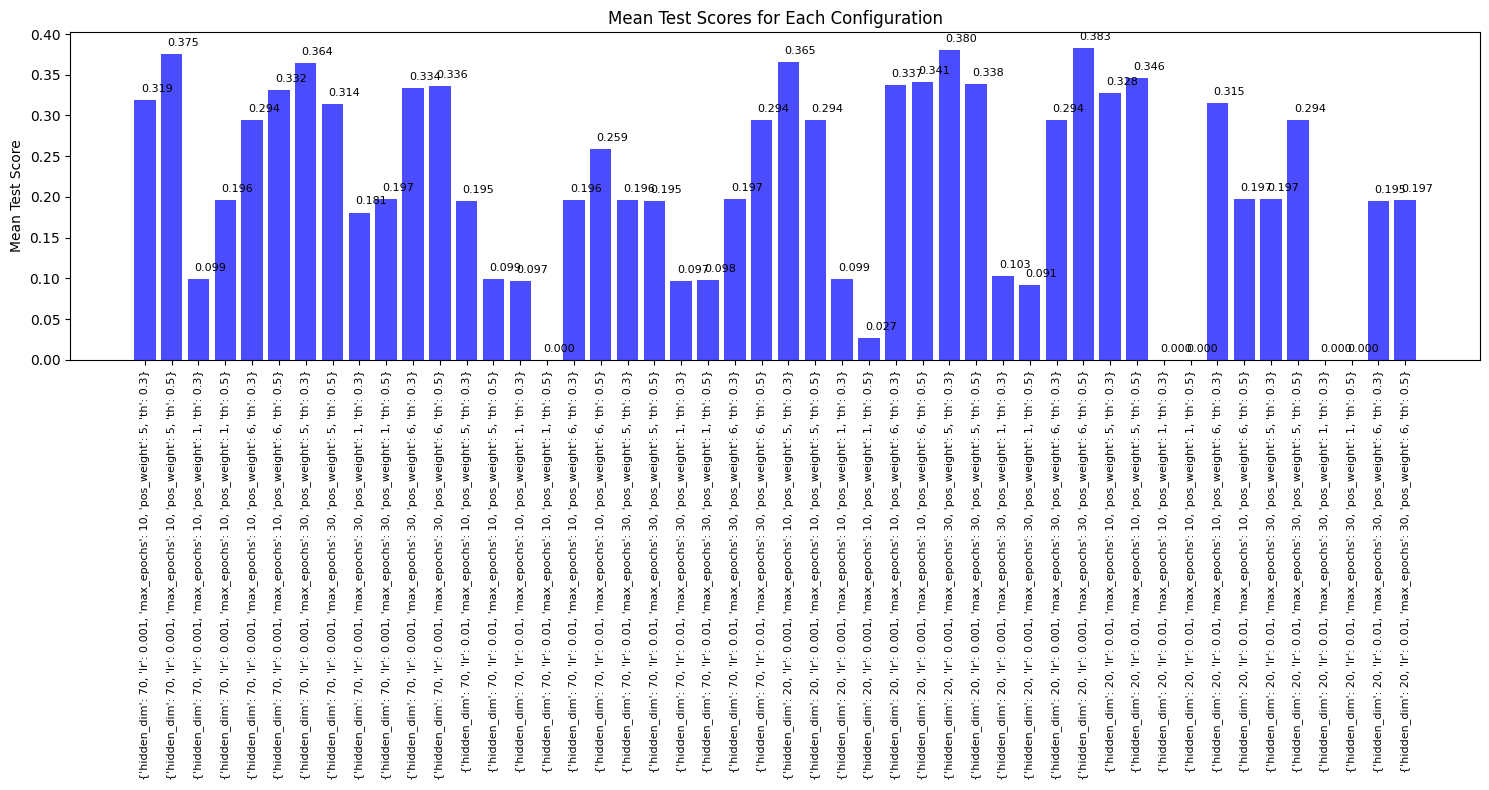

In [8]:
trainer.plot_results()